## Model Evaluation

This notebook purpouse is to evaluate our model performance through our valid/test sets. <br>
The model chosen is a Gradient Boosting (Lightgbm) due to its high performance. <br>
Other architectures, as well as methods such as enseemble and stacking werent experimented with due time constraints.

In [25]:
from sklearn.metrics import roc_curve, precision_score, recall_score, precision_recall_curve

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

pd.options.display.max_columns = 99

from tqdm import tqdm

In [2]:
train = pd.read_csv('../data/model_evaluation_data/train_set.csv')
valid = pd.read_csv('../data/model_evaluation_data/valid_set.csv')
test = pd.read_csv('../data/model_evaluation_data/test_set.csv')

In [3]:
train_X = train.drop(['target'],1)
train_y = train['target']

valid_X = valid.drop(['target'],1)
valid_y = valid['target']

test_X = test.drop(['target'],1)
test_y = test['target']

In [4]:
lgb_train = lgb.Dataset(train_X, train_y)
lgb_valid = lgb.Dataset(valid_X, valid_y, reference=lgb_train)

The metric used was roc-auc, as it tries to optimize both recall and precision. <br>
The parameters were manually tunned through experimentation. <br>
Parameter optimization is usually done through grid search methods. <br>
Bayesian Optimization seems like a more efficient alternative to grid search. ( https://github.com/fmfn/BayesianOptimization )

In [15]:
log = pd.DataFrame([], columns=['params','valid_score','valid_recall','valid_precision','test_recall','test_precision'])

feature_name = list(train_X.columns)

np.random.seed(42)

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=50000,
                valid_sets=[lgb_train,lgb_valid],  # eval training data
                early_stopping_rounds = 100,
                verbose_eval=500,
                feature_name=feature_name)

Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.841701	valid_1's auc: 0.780935
[1000]	training's auc: 0.867147	valid_1's auc: 0.78841
[1500]	training's auc: 0.882351	valid_1's auc: 0.791009
Early stopping, best iteration is:
[1653]	training's auc: 0.886157	valid_1's auc: 0.791414


In [16]:
valid_preds = np.round(gbm.predict(valid_X))
test_preds = np.round(gbm.predict(test_X))

test_recall = recall_score(test_y, test_preds)
test_precision = precision_score(test_y, test_preds)

valid_recall = recall_score(valid_y, valid_preds)
valid_precision = precision_score(valid_y, valid_preds)

validation and test results are very similar - which suggests there was no overfitting.

In [23]:
print ('validation recall:\t',np.round(valid_recall,2))
print ('validation precision:\t', np.round(valid_precision,2))
print ('test recall:\t\t',np.round(test_recall,2))
print ('test precision\t\t', np.round(test_precision,2))

validation recall:	 0.88
validation precision:	 0.73
test recall:		 0.89
test precision		 0.74


feature importance shows that time features are relevant. <br>
further feature engineering should try to explore that. <br>
analysis should try to find the reason behind that.

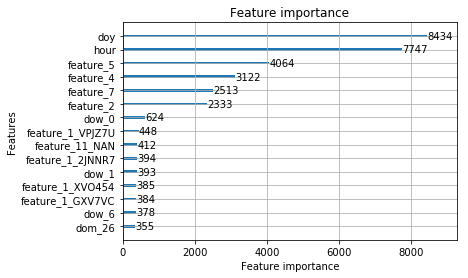

In [24]:
lgb.plot_importance(gbm, max_num_features=15)

In [28]:
fpr, tpr, thresholds_1 = roc_curve(valid_y,gbm.predict(valid_X))
precision, recall, thresholds_2 = precision_recall_curve(valid_y,gbm.predict(valid_X))

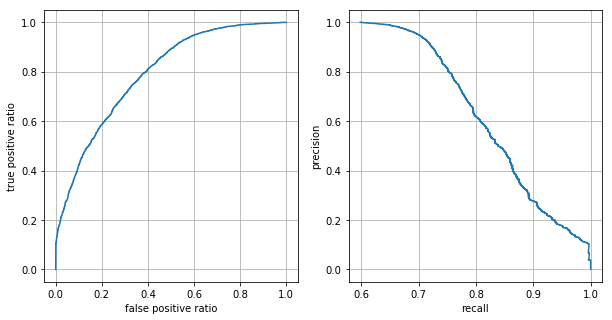

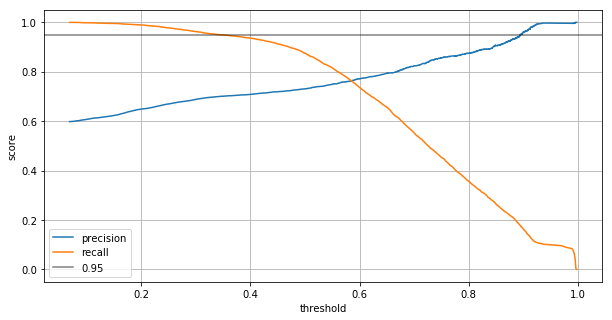

In [54]:
plt.figure(figsize=(10,5))

plt.subplot(121)

plt.plot(fpr, tpr)
plt.ylabel('true positive ratio')
plt.xlabel('false positive ratio')
plt.grid()

plt.subplot(122)

plt.plot(precision, recall)
plt.ylabel('precision')
plt.xlabel('recall')
plt.grid();

plt.figure(figsize=(10,5))

plt.plot(thresholds_2, precision[1:])
plt.plot(thresholds_2, recall[1:])
plt.axhline(y=0.95, color='black', alpha=0.5)
plt.ylabel('score')
plt.xlabel('threshold')
plt.grid();
plt.legend(['precision','recall','0.95'])

In [78]:
print ('max recall with precision >=0.95:', np.round(recall[min(np.where(precision>0.95)[0])],2))

max recall with precision >=0.95: 0.18


While its possible to mantain a precision => 95% that implies a low recall.  <br>
It (might) also be possible to obtain significant better results with further feature engineering / using other model architectures. <br>

now lets build the actual model / predictions. <br>

In [82]:
df = pd.read_csv('../data/model_final_data/final.csv')
df.drop('feature_0',1, inplace=True)

In [85]:
train = df.loc[df['target'].notnull()]
test = df.loc[df['target'].isnull()]

In [87]:
train_X = train.drop(['id','target'],1)
train_y = train['target']

test_X = test.drop(['id','target'],1)

In [88]:
lgb_train = lgb.Dataset(train_X, train_y)

In [89]:
np.random.seed(42)

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1653,
                feature_name=feature_name)

In [90]:
test_preds = gbm.predict(test_X)

In [96]:
sample_sub = pd.DataFrame(columns=['id','pred'])
sample_sub['id'] = test['id'].values
sample_sub['pred'] = test_preds

In [98]:
sample_sub.to_csv('../data/sub.csv', index=False)